In [1]:
import torch
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import data_processing, visualization, statistic
import time
import pandas as pd
import warnings
import sksurv as sks
from sksurv.datasets import load_gbsg2
from sksurv.nonparametric import kaplan_meier_estimator#
from lifelines import CoxPHFitter
warnings.filterwarnings("ignore")

In [2]:
X,Y = load_gbsg2()
print(X.columns)

Index(['age', 'estrec', 'horTh', 'menostat', 'pnodes', 'progrec', 'tgrade',
       'tsize'],
      dtype='object')


In [3]:
censoring = []
time = []
for delta, t in Y:
    censoring.append(delta)
    time.append(t)

In [4]:
gbsg2 = X.copy()
gbsg2['time'] = time
gbsg2['censoring'] = censoring

In [5]:
gbsg2.head()

,age,estrec,horTh,menostat,pnodes,progrec,tgrade,tsize,time,censoring
0,70.0,66.0,no,Post,3.0,48.0,II,21.0,1814.0,True
1,56.0,77.0,yes,Post,7.0,61.0,II,12.0,2018.0,True
2,58.0,271.0,yes,Post,9.0,52.0,II,35.0,712.0,True
3,59.0,29.0,yes,Post,4.0,60.0,II,17.0,1807.0,True
4,73.0,65.0,no,Post,1.0,26.0,II,35.0,772.0,True


In [6]:
gbsg2['tgrade']

0       II
1       II
2       II
3       II
4       II
      ... 
681    III
682    III
683    III
684     II
685     II
Name: tgrade, Length: 686, dtype: category
Categories (3, object): ['I', 'II', 'III']

In [7]:
#for col in data.columns:
#    print(np.unique(data[col]))
gbsg2['horTh'] = gbsg2['horTh'].replace({'yes': 1, 'no': 0})
gbsg2['menostat'] = gbsg2['menostat'].replace({'Post': 1, 'Pre': 0})
gbsg2['tgrade'] = gbsg2['tgrade'].replace({'I': 1, 'II': 2, 'III': 3 })
gbsg2['censoring'] = gbsg2['censoring'].replace({True: 1, False: 0})
gbsg2.head()

,age,estrec,horTh,menostat,pnodes,progrec,tgrade,tsize,time,censoring
0,70.0,66.0,0,1,3.0,48.0,2,21.0,1814.0,1
1,56.0,77.0,1,1,7.0,61.0,2,12.0,2018.0,1
2,58.0,271.0,1,1,9.0,52.0,2,35.0,712.0,1
3,59.0,29.0,1,1,4.0,60.0,2,17.0,1807.0,1
4,73.0,65.0,0,1,1.0,26.0,2,35.0,772.0,1


In [8]:
dataset_name = "gbsg2"
data_file= "dataset/" + dataset_name + "/data.csv"
gbsg2.to_csv(data_file,header=False,index=False)

In [9]:
from utils import data_processing, visualization, statistic



feat_types_file = "dataset/" + dataset_name + "/data_types.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = "dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

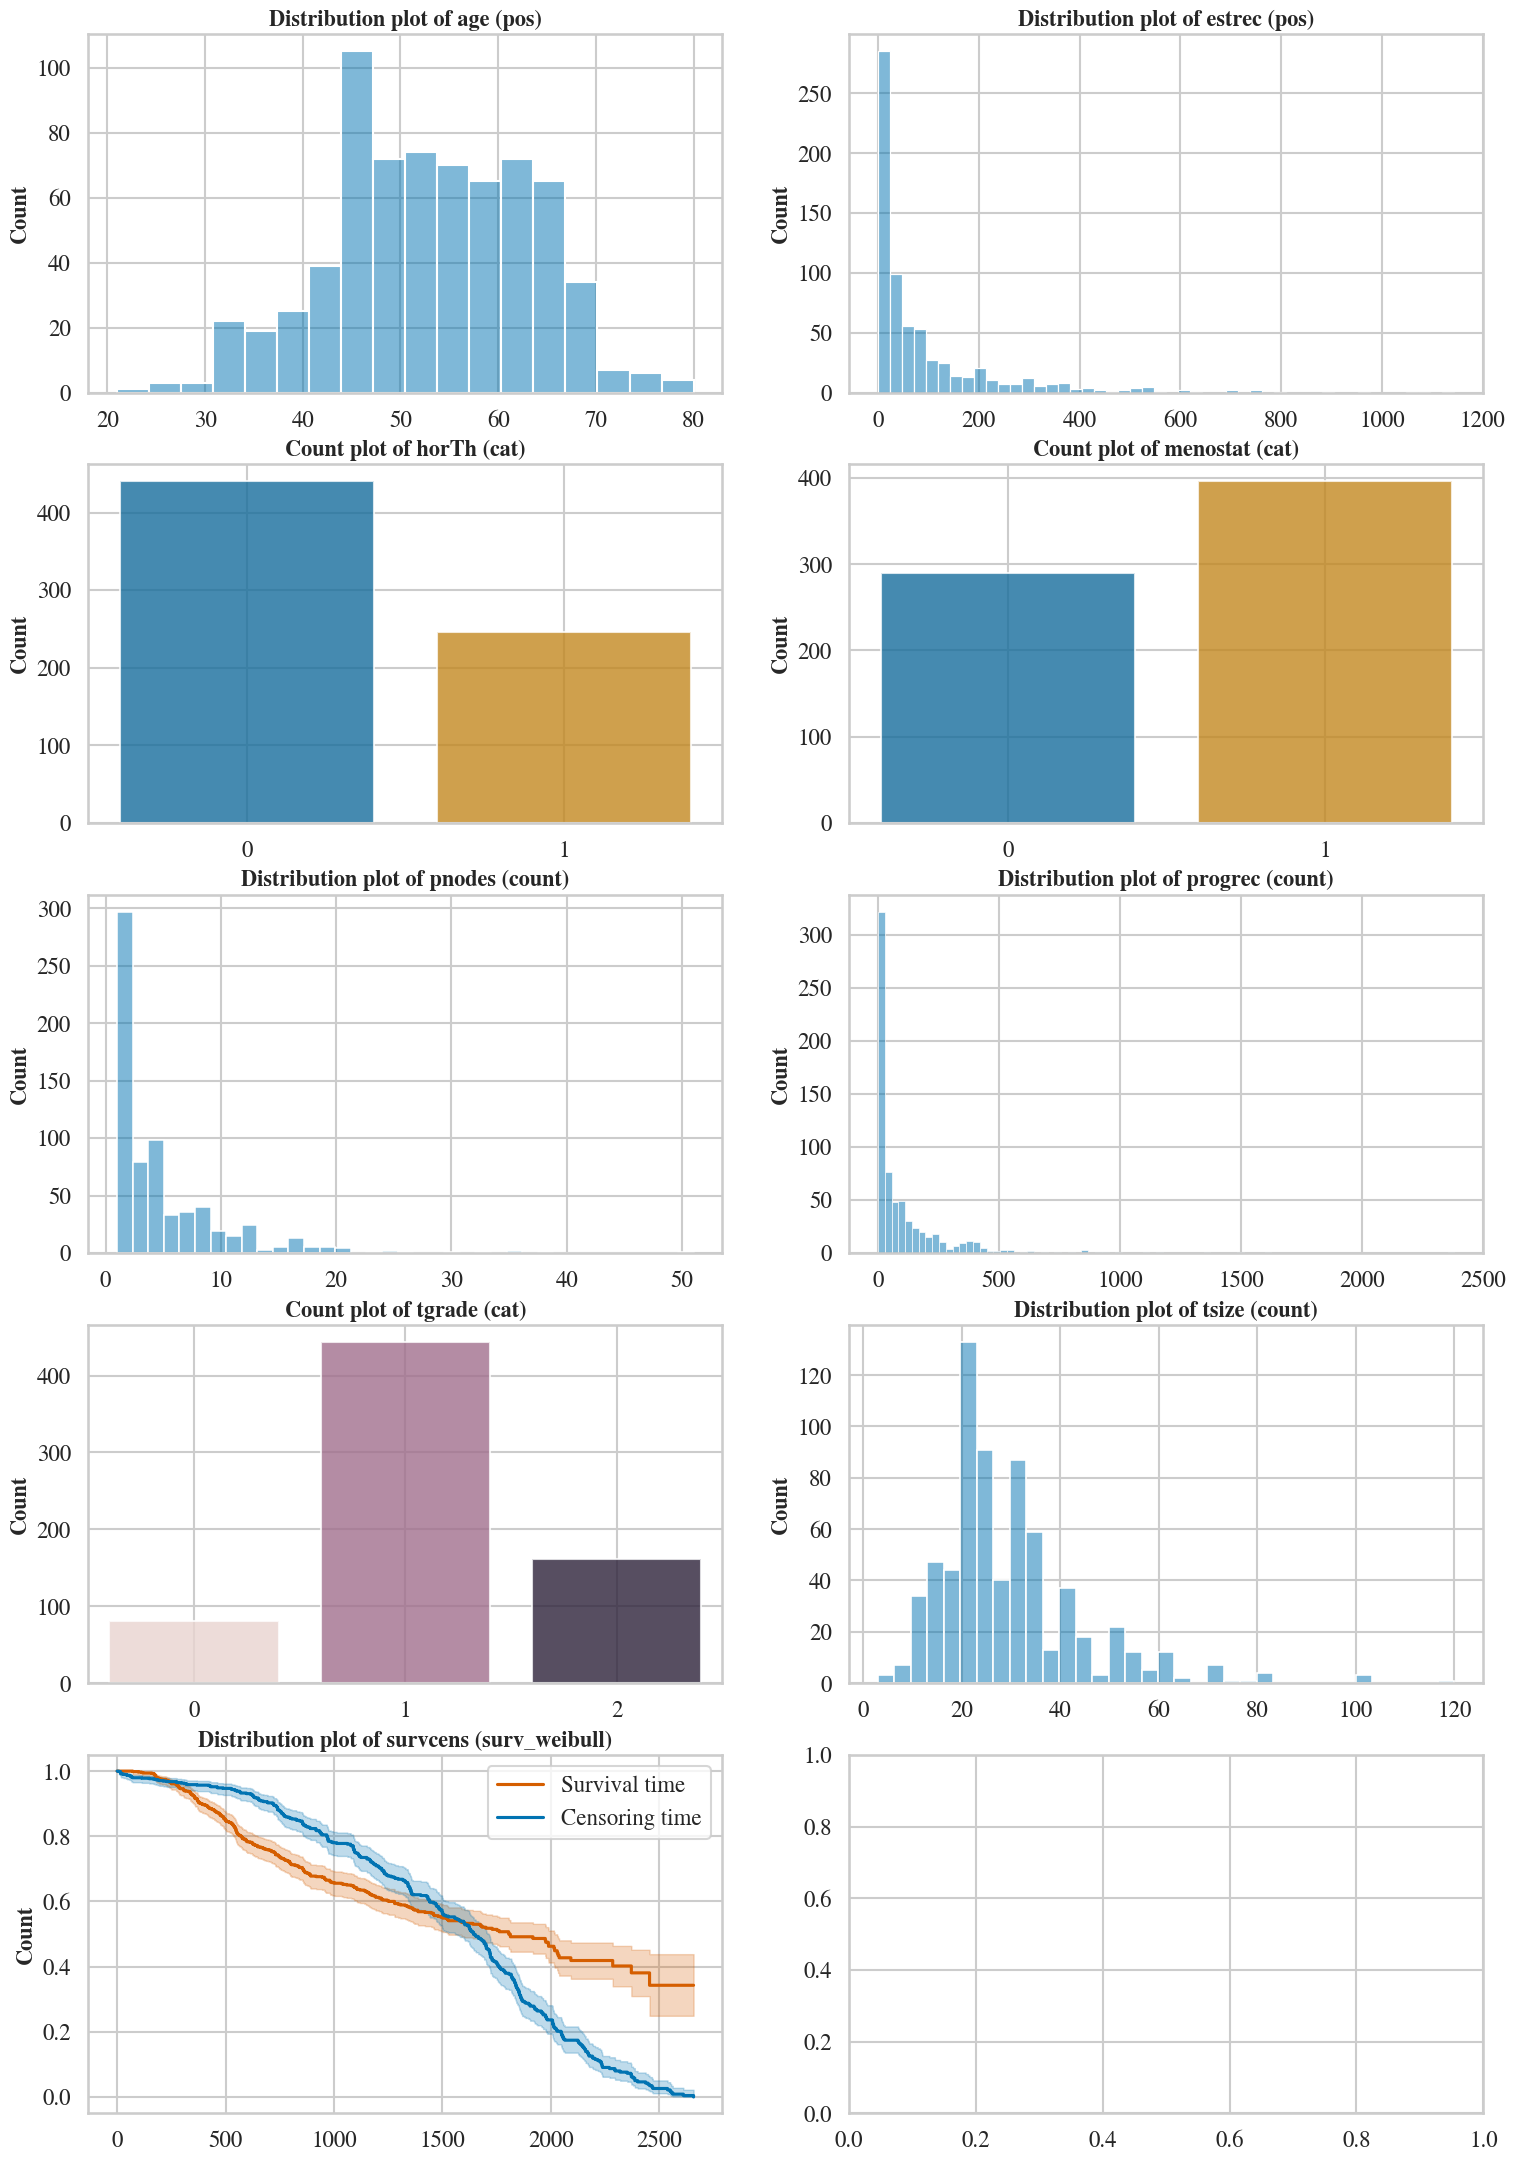

In [10]:
# Load training data
data, feat_types_dict, miss_mask, true_miss_mask, n_samples = data_processing.read_data(data_file, feat_types_file, miss_file, true_miss_file)

# Feature analysis
data_transformed = data_processing.discrete_variables_transformation(data, feat_types_dict)
#features_df = pd.DataFrame(data_transformed, columns=["feat_" + str(i+1) for i in range(data_transformed.shape[1])])

visualization.plot_data(data_transformed, feat_types_dict)

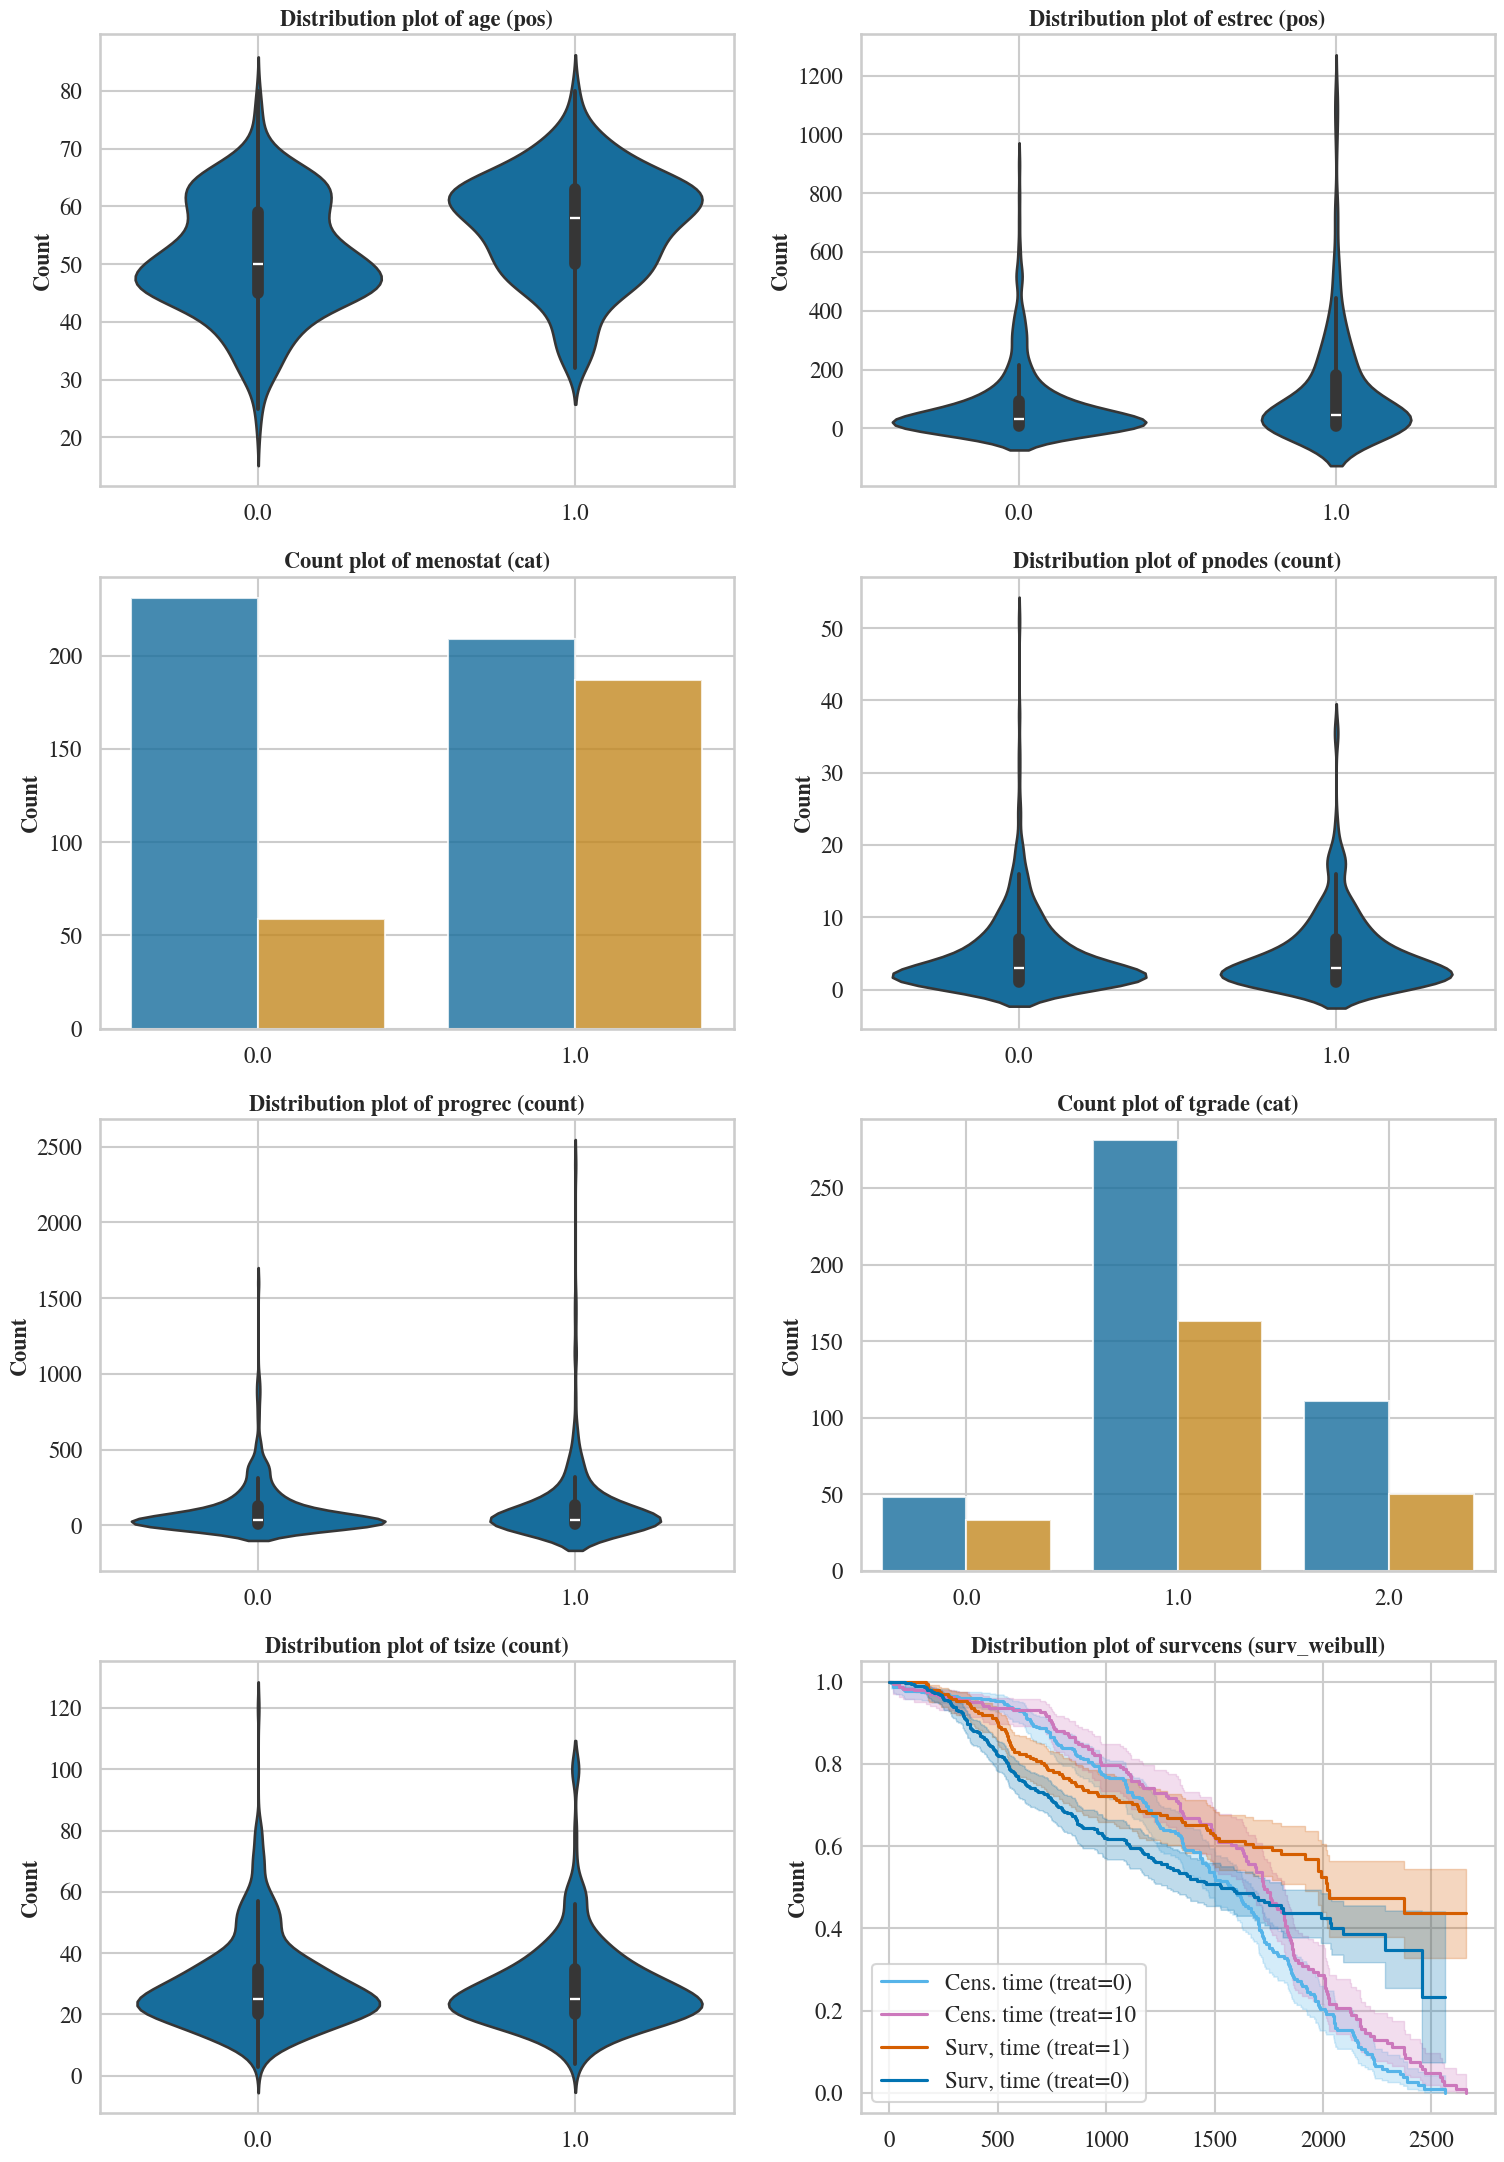

In [11]:
visualization.plot_compare_data(data_transformed, feat_types_dict,feat_comparison_name = 'horTh')

In [13]:
feat_types_dict

[{'name': 'age', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'estrec', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'name': 'horTh', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'menostat', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'name': 'pnodes', 'type': 'count', 'dim': '1', 'nclass': ''},
 {'name': 'progrec', 'type': 'count', 'dim': '1', 'nclass': ''},
 {'name': 'tgrade', 'type': 'cat', 'dim': '1', 'nclass': '3'},
 {'name': 'tsize', 'type': 'count', 'dim': '1', 'nclass': ''},
 {'name': 'survcens', 'type': 'surv_weibull', 'dim': '2', 'nclass': ''}]

### Experiment setting

In [14]:
gbsg2_treated = gbsg2[gbsg2['horTh']==1].drop(["horTh"] , axis =1)
gbsg2_control = gbsg2[gbsg2['horTh']==0].drop(["horTh"] , axis =1)

In [15]:
gbsg2_control.head()

,age,estrec,menostat,pnodes,progrec,tgrade,tsize,time,censoring
0,70.0,66.0,1,3.0,48.0,2,21.0,1814.0,1
4,73.0,65.0,1,1.0,26.0,2,35.0,772.0,1
5,32.0,13.0,0,24.0,0.0,3,57.0,448.0,1
7,65.0,25.0,1,1.0,192.0,2,16.0,2161.0,0
8,80.0,59.0,1,30.0,0.0,2,39.0,471.0,1


In [16]:
gbsg2_control.shape

(440, 9)

In [17]:
np.sum(gbsg2_control["censoring"])

np.int64(205)

In [18]:
data_file_treated= "dataset/" + dataset_name + "/data_treated.csv"
gbsg2_treated.to_csv(data_file_treated,header=False,index=False)
data_file_control= "dataset/" + dataset_name + "/data_control.csv"
gbsg2_control.to_csv(data_file_control,header=False,index=False)


In [19]:
gbsg2_control.columns

Index(['age', 'estrec', 'menostat', 'pnodes', 'progrec', 'tgrade', 'tsize',
       'time', 'censoring'],
      dtype='object')

In [20]:
def encode_and_bind(original_dataframe, feature_to_encode):
    #print(np.unique(original_dataframe[feature_to_encode]))#.shape[0])
    if np.unique(original_dataframe[feature_to_encode]).shape[0] > 2 :
        dummies = pd.get_dummies(original_dataframe[feature_to_encode],drop_first=True, prefix=feature_to_encode, prefix_sep='')
        res = pd.concat([original_dataframe, dummies], axis=1)
        #print(res.head())
        res = res.drop([feature_to_encode], axis=1)
    else:
        res = original_dataframe
    return(res) 

categorical_encode = ['horTh', 'menostat', 'tgrade']


In [21]:
gbsg2_oh = gbsg2.copy()
for feat in categorical_encode:
    gbsg2_oh = encode_and_bind(gbsg2_oh,feat)

In [22]:
# Fit the Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(gbsg2_oh, duration_col='time', event_col='censoring')

# Display summary statistics of the model
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 686 total observations, 387 right-censored observations>
             duration col = 'time'
                event col = 'censoring'
      baseline estimation = breslow
   number of observations = 686
number of events observed = 299
   partial log-likelihood = -1735.73
         time fit was run = 2025-03-13 10:51:38 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age       -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
estrec     0.00      1.00      0.00           -0.00            0.00                1.00                1.00
horTh     -0.35      0.71      0.13           -0.60           -0.09                0.55                0.91
menostat   0.26      1.29      0.18           -0.10            0.62                0.90                1.86
pnodes     0.05      1.05      0.01            0.03            0.06                1.03                1.07
progrec   -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
tsize      0.01      1.01      0.00            0.00            0.02                1.00                1.02
tgrade2    0.64      1.89      0.25            0.15            1.12                1.16                3.08
tgrade3    0.78      2.18      0.27            0.25            1.31                1.29                3.69

           cmp to     z      p  -log2(p)
covariate                               
age          0.00 -1.02   0.31      1.69
estrec       0.00  0.44   0.66      0.60
horTh        0.00 -2.68   0.01      7.10
menostat     0.00  1.41   0.16      2.65
pnodes       0.00  6.55 <0.005     34.03
progrec      0.00 -3.87 <0.005     13.14
tsize        0.00  1.98   0.05      4.39
tgrade2      0.00  2.55   0.01      6.55
tgrade3      0.00  2.90 <0.005      8.08
---
Concordance = 0.69
Partial AIC = 3489.46
log-likelihood ratio test = 104.75 on 9 df
-log2(p) of ll-ratio test = 59.01